In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy, ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, get_default_features, get_default_vision_features, get_default_lang_features, MOD_SPECIFIC_IMAGES, MOD_SPECIFIC_CAPTIONS
from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN

# Zero-shot cross-modal decoding

In [2]:
all_data = load_results_data()

100%|██████████| 874/874 [00:16<00:00, 54.21it/s]


In [3]:
MODEL_ORDER = ["random-flava", "clip", "flava", "imagebind", "blip2"]

all_data = all_data[all_data.model.isin(MODEL_ORDER)]
all_data

,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,lang_features,model_feat
24,100000.0,blip2,sub-01,avg,vision_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.855918,lang_features_cls,blip2_avg
25,100000.0,blip2,sub-01,avg,vision_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.824898,lang_features_cls,blip2_avg
26,100000.0,blip2,sub-01,avg,vision_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.928571,lang_features_cls,blip2_avg
27,100000.0,blip2,sub-01,avg,vision_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.876735,lang_features_cls,blip2_avg
28,100000.0,blip2,sub-01,avg,vision_features_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.853980,lang_features_mean,blip2_avg
...,...,...,...,...,...,...,...,...,...,...,...,...
3435,100000.0,imagebind,sub-07,concat,vision_features_cls,images,whole_brain,214739,pairwise_acc_mean,0.863367,lang_features_cls,imagebind_concat
3436,100000.0,imagebind,sub-07,matched,vision_features_cls,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.817653,lang_features_cls,imagebind_matched
3437,100000.0,imagebind,sub-07,matched,vision_features_cls,images,whole_brain,214739,pairwise_acc_captions,0.737347,lang_features_cls,imagebind_matched
3438,100000.0,imagebind,sub-07,matched,vision_features_cls,images,whole_brain,214739,pairwise_acc_images,0.939388,lang_features_cls,imagebind_matched


In [4]:
data_cls_feats = all_data.copy()
for model in all_data.model.unique():
    data_cls_feats = data_cls_feats[((data_cls_feats.model == model) & (data_cls_feats.vision_features == "vision_features_cls") & (data_cls_feats.lang_features == "lang_features_cls")) | (data_cls_feats.model != model)]
    
data_matched_feats = data_cls_feats[data_cls_feats.features == "matched"]

In [5]:
def add_mean_cross_modal_and_within_modal_rows(data):
    extra_rows = []
    for model in data.model.unique():
        for subject in SUBJECTS:
            data_model_subj = data[(data.model == model) & (data.subject == subject)]
            # cross-modal
            cross_modal_train_images_eval_captions = data_model_subj[(data_model_subj.training_mode == "images") & (data_model_subj.metric == ACC_CAPTIONS)]
            cross_modal_train_captions_eval_images = data_model_subj[(data_model_subj.training_mode == "captions") & (data_model_subj.metric == ACC_IMAGES)]
    
            if len(cross_modal_train_captions_eval_images) > 0:
                assert len(cross_modal_train_images_eval_captions) == len(cross_modal_train_captions_eval_images) == 1
                mean_acc = (cross_modal_train_images_eval_captions.value.item() + cross_modal_train_captions_eval_images.value.item()) / 2
        
                mean_row = cross_modal_train_images_eval_captions.copy()
                mean_row["training_mode"] = "cross-modal"
                mean_row["metric"] = "mean"
                mean_row["value"] = mean_acc
                mean_row["condition"] = "cross-modal"
    
                extra_rows.append(mean_row)
    
            # within-modal
            within_modal_captions = data_model_subj[(data_model_subj.training_mode == "captions") & (data_model_subj.metric == ACC_CAPTIONS)]
            within_modal_images = data_model_subj[(data_model_subj.training_mode == "images") & (data_model_subj.metric == ACC_IMAGES)]
    
            if len(within_modal_captions) > 0:
                assert len(within_modal_captions) == len(within_modal_images) == 1
                mean_acc = (within_modal_captions.value.item() + within_modal_images.value.item()) / 2
        
                mean_row = within_modal_captions.copy()
                mean_row["training_mode"] = "within-modal"
                mean_row["metric"] = "mean"
                mean_row["value"] = mean_acc
                mean_row["condition"] = "within-modal"
    
                extra_rows.append(mean_row)
    
    extra_rows = pd.concat(extra_rows)
    data = pd.concat((data, extra_rows), ignore_index=True)
    return data
    # data_matched_with_mean[data_matched_with_mean.metric == "mean"]

In [6]:
data_matched_feats = add_mean_cross_modal_and_within_modal_rows(data_matched_feats)

In [7]:
DEFAULT_FEAT_OPTIONS = ["vision", "lang", "matched"]

def calc_model_feat_order(data, feat_options=DEFAULT_FEAT_OPTIONS, model_order=MODEL_ORDER):
    all_model_feats = data.model_feat.unique()
    all_models = data.model.unique()
    for model in all_models:
        if model not in MODEL_ORDER:
            raise RuntimeError(f"Model missing in order: {model}")
    model_feat_order = []
    for model in MODEL_ORDER:
        for feats in feat_options:
            model_feat = f"{model}_{feats}"
            if model_feat in all_model_feats:
                model_feat_order.append(model_feat)

    return model_feat_order

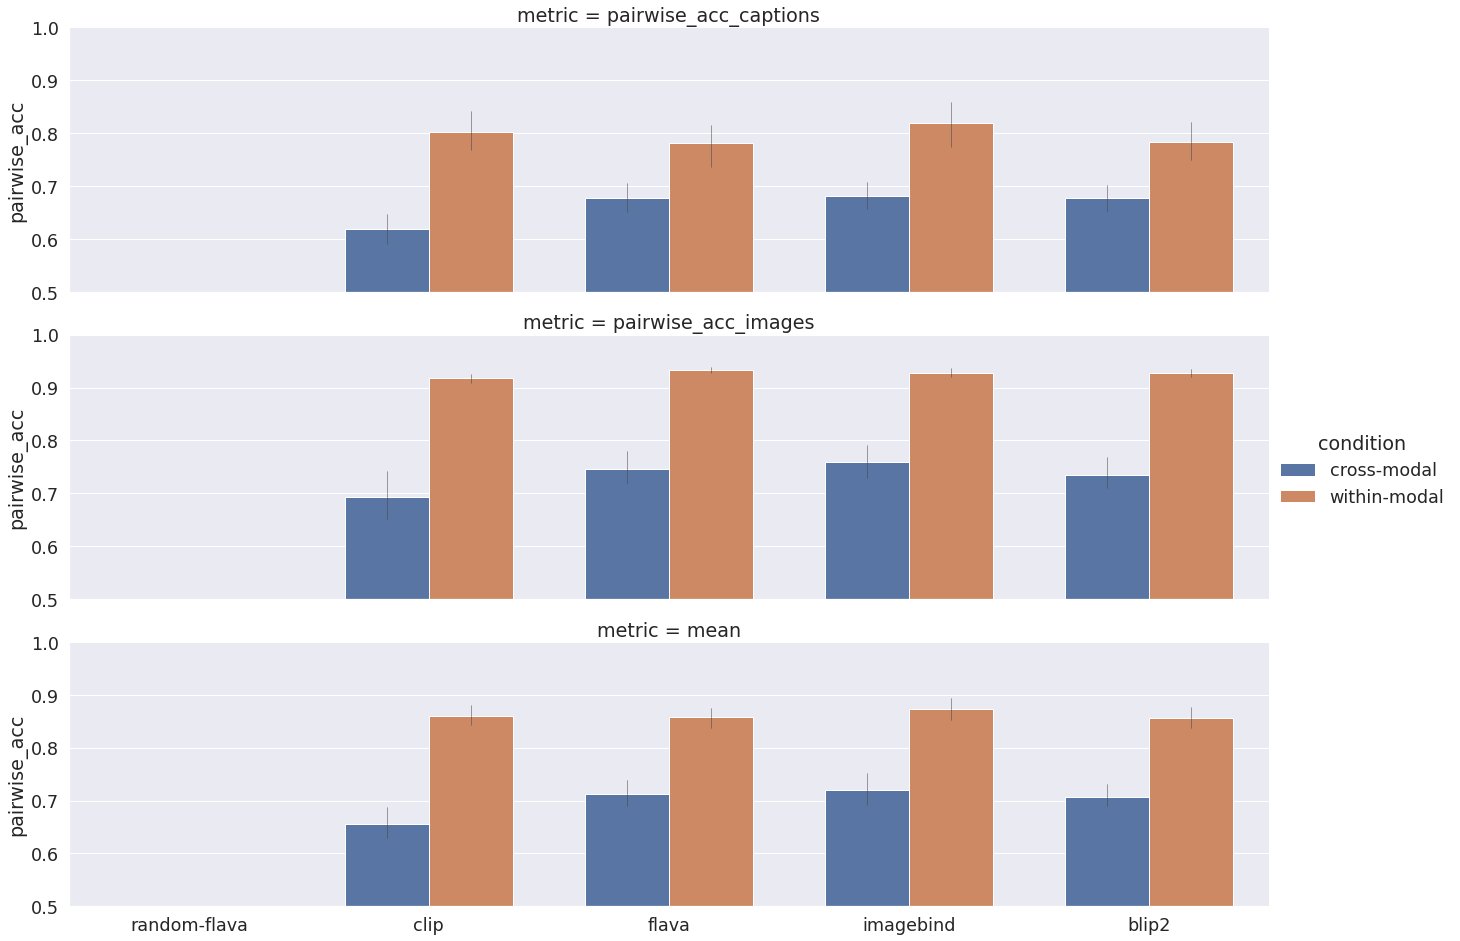

In [8]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_matched_feats.copy()

data_to_plot = data_to_plot[data_to_plot.training_mode != "modality-agnostic"]

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "matched": "multimodal models"})

data_to_plot.loc[((data_to_plot.training_mode == "images") & (data_to_plot.metric == ACC_CAPTIONS)) | ((data_to_plot.training_mode == "captions") & (data_to_plot.metric == ACC_IMAGES)), "condition"] = "cross-modal"
data_to_plot.loc[((data_to_plot.training_mode == "captions") & (data_to_plot.metric == ACC_CAPTIONS)) | ((data_to_plot.training_mode == "images") & (data_to_plot.metric == ACC_IMAGES)), "condition"] = "within-modal"

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot)

# data_to_plot["metric"] = data_to_plot.metric.replace({ACC_CAPTIONS: "zero_shot_train_images_eval_captions", ACC_IMAGES: "zero_shot_train_captions_eval_images"})


metrics_order = [ACC_CAPTIONS, ACC_IMAGES, "mean"]

height = 4.5
aspect = 4

condition_order = ["cross-modal", "within-modal"]

for mode in ["captions", "images", "cross-modal", "within-modal"]:
    data_mode = data_to_plot[data_to_plot.training_mode == mode]
    for model in MODEL_ORDER:
        for condition in condition_order:
            length = len(data_mode[(data_mode.model == model) & (data_mode.condition == condition)])
            expected_num_datapoints = len(SUBJECTS)
            if (length > 0) and (length != expected_num_datapoints):
                message = f"unexpected number of datapoints: {length} (expected: {expected_num_datapoints}) (model_feat: {model} {mode})"
                print(f"Warning: {message}")
            
g = sns.catplot(data_to_plot, kind="bar", x="model", order=MODEL_ORDER, y="value", row="metric", row_order=metrics_order, col=None, height=height, aspect=aspect, hue="condition", hue_order=condition_order,
                palette=None, err_kws={'linewidth': 0.5, 'alpha': 0.99}, width=0.7)
   
g.set(ylim=(0.5, 1), ylabel="pairwise_acc", xlabel='')





# figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
#                              legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,0.98), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_zero_shot_cross_modal_decoding.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


# Zero-shot cross-modal decoding with GloW

In [9]:
all_data = load_results_data()
MODEL_ORDER = ["resnet-50-glow", "bge", "resnet-and-bge", "glow", "glow-contrastive"]

all_data = all_data[all_data.model.isin(MODEL_ORDER)]
all_data

100%|██████████| 874/874 [00:00<00:00, 1223.00it/s]


,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,lang_features,model_feat
8,100000.0,bge,sub-01,lang,n_a,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.842653,lang_features_cls,bge_lang
9,100000.0,bge,sub-01,lang,n_a,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.813469,lang_features_cls,bge_lang
10,100000.0,bge,sub-01,lang,n_a,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.902857,lang_features_cls,bge_lang
11,100000.0,bge,sub-01,lang,n_a,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.858163,lang_features_cls,bge_lang
168,100000.0,glow-contrastive,sub-01,concat,vision_features_mean,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.848061,lang_features_cls,glow-contrastive_concat
...,...,...,...,...,...,...,...,...,...,...,...,...
3471,100000.0,resnet-50-glow,sub-07,vision,vision_features_mean,images,whole_brain,214739,pairwise_acc_mean,0.824796,n_a,resnet-50-glow_vision
3476,100000.0,resnet-and-bge,sub-07,concat,vision_features_mean,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.803367,lang_features_cls,resnet-and-bge_concat
3477,100000.0,resnet-and-bge,sub-07,concat,vision_features_mean,images,whole_brain,214739,pairwise_acc_captions,0.748367,lang_features_cls,resnet-and-bge_concat
3478,100000.0,resnet-and-bge,sub-07,concat,vision_features_mean,images,whole_brain,214739,pairwise_acc_images,0.939796,lang_features_cls,resnet-and-bge_concat


In [10]:
data_cls_feats = all_data.copy()
# for model in all_data.model.unique():
#     data_cls_feats = data_cls_feats[((data_cls_feats.model == model) & (data_cls_feats.vision_features == "vision_features_cls") & (data_cls_feats.lang_features == "lang_features_cls")) | (data_cls_feats.model != model)]

data_matched_feats = data_cls_feats[data_cls_feats.features == "matched"]


In [11]:
data_matched_feats = add_mean_cross_modal_and_within_modal_rows(data_matched_feats)
data_matched_feats

,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,lang_features,model_feat,condition
0,100000.0,glow-contrastive,sub-01,matched,vision_features_mean,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.846939,lang_features_cls,glow-contrastive_matched,NaN
1,100000.0,glow-contrastive,sub-01,matched,vision_features_mean,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.807755,lang_features_cls,glow-contrastive_matched,NaN
2,100000.0,glow-contrastive,sub-01,matched,vision_features_mean,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.914082,lang_features_cls,glow-contrastive_matched,NaN
3,100000.0,glow-contrastive,sub-01,matched,vision_features_mean,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.860918,lang_features_cls,glow-contrastive_matched,NaN
4,100000.0,glow,sub-01,matched,vision_features_mean,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.848367,lang_features_cls,glow_matched,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,100000.0,glow,sub-04,matched,vision_features_mean,within-modal,whole_brain,226242,mean,0.853878,lang_features_cls,glow_matched,within-modal
164,100000.0,glow,sub-05,matched,vision_features_mean,cross-modal,whole_brain,188225,mean,0.706633,lang_features_cls,glow_matched,cross-modal
165,100000.0,glow,sub-05,matched,vision_features_mean,within-modal,whole_brain,188225,mean,0.802653,lang_features_cls,glow_matched,within-modal
166,100000.0,glow,sub-07,matched,vision_features_mean,cross-modal,whole_brain,214739,mean,0.805510,lang_features_cls,glow_matched,cross-modal


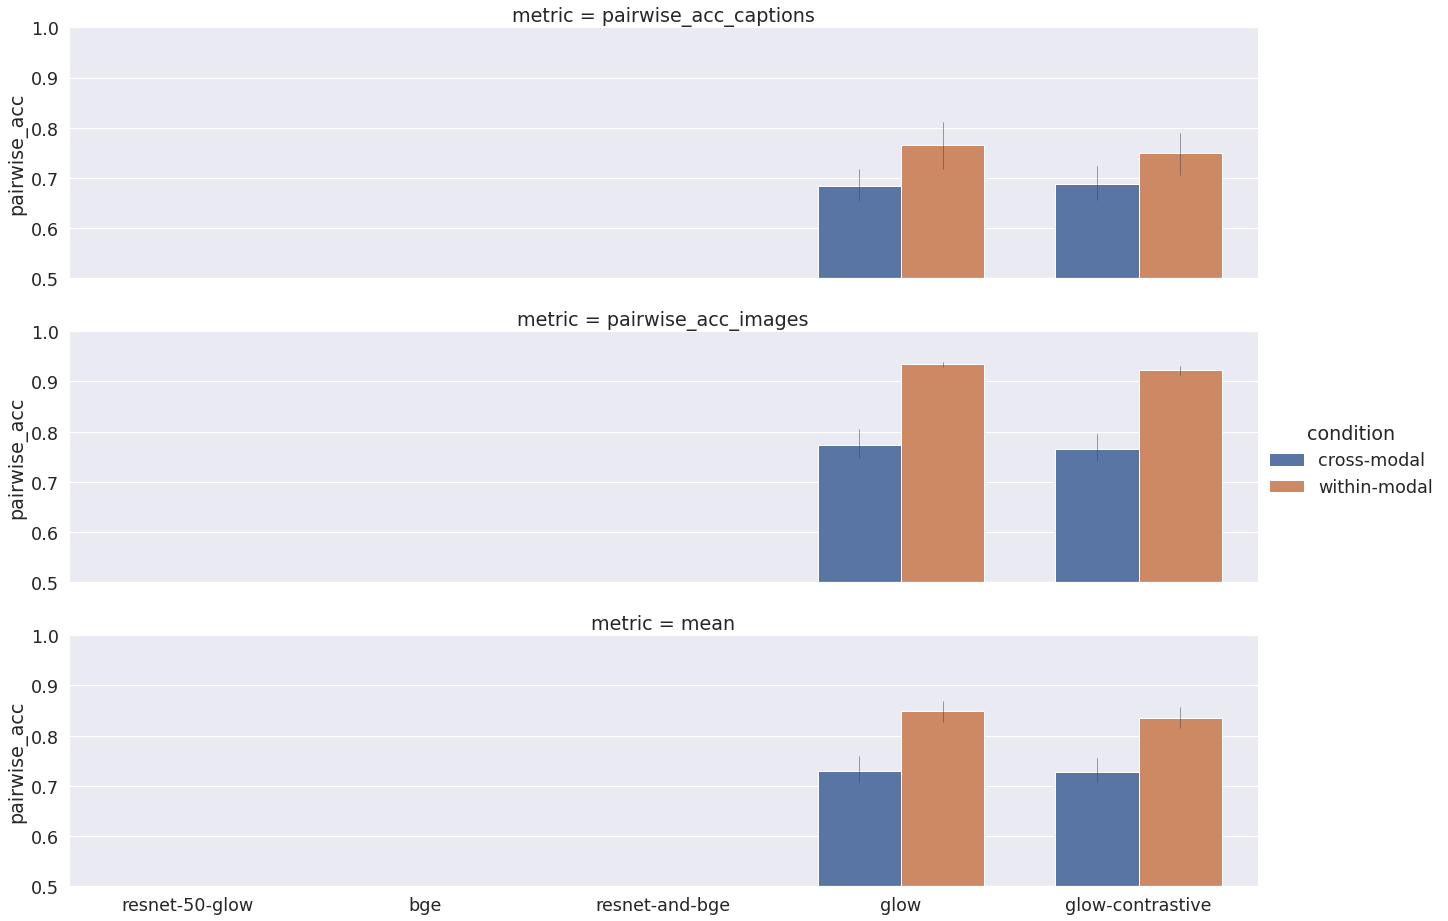

In [12]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_matched_feats.copy()

data_to_plot = data_to_plot[data_to_plot.training_mode != "modality-agnostic"]

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "matched": "multimodal models"})

data_to_plot.loc[((data_to_plot.training_mode == "images") & (data_to_plot.metric == ACC_CAPTIONS)) | ((data_to_plot.training_mode == "captions") & (data_to_plot.metric == ACC_IMAGES)), "condition"] = "cross-modal"
data_to_plot.loc[((data_to_plot.training_mode == "captions") & (data_to_plot.metric == ACC_CAPTIONS)) | ((data_to_plot.training_mode == "images") & (data_to_plot.metric == ACC_IMAGES)), "condition"] = "within-modal"

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot, MODEL_ORDER)

# data_to_plot["metric"] = data_to_plot.metric.replace({ACC_CAPTIONS: "zero_shot_train_images_eval_captions", ACC_IMAGES: "zero_shot_train_captions_eval_images"})


metrics_order = [ACC_CAPTIONS, ACC_IMAGES, "mean"]

height = 4.5
aspect = 4

condition_order = ["cross-modal", "within-modal"]

for mode in ["captions", "images", "cross-modal", "within-modal"]:
    data_mode = data_to_plot[data_to_plot.training_mode == mode]
    for model in MODEL_ORDER:
        for condition in condition_order:
            length = len(data_mode[(data_mode.model == model) & (data_mode.condition == condition)])
            expected_num_datapoints = len(SUBJECTS)
            if (length > 0) and (length != expected_num_datapoints):
                message = f"unexpected number of datapoints: {length} (expected: {expected_num_datapoints}) (model_feat: {model} {mode})"
                print(f"Warning: {message}")
            
g = sns.catplot(data_to_plot, kind="bar", x="model", order=MODEL_ORDER, y="value", row="metric", row_order=metrics_order, col=None, height=height, aspect=aspect, hue="condition", hue_order=condition_order,
                palette=None, err_kws={'linewidth': 0.5, 'alpha': 0.99}, width=0.7)
   
g.set(ylim=(0.5, 1), ylabel="pairwise_acc", xlabel='')





# figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
#                              legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,0.98), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_zero_shot_cross_modal_decoding.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)
